# Code from Jake's jupyter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#import sklearn.metrics as sk
import scipy.stats
from scipy.optimize import curve_fit
#from RegscorePy import *
from IPython.core.debugger import set_trace
import seaborn as sns
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import lmfit 
import matplotlib.lines as mlines


import pandas as pd
#import import_ipynb
#import KEM_Rand

In [2]:
data = pd.read_csv("../empiricalAnalysis/CTScalingFiles/ct.distr.csv")
idmappings = pd.read_excel("../empiricalAnalysis/CTScalingFiles/cbsaidmappings.xls").set_index("CBSA Code")



In [3]:
idmappings.head()

,Metro Division Code,CSA Code,CBSA Title,Metropolitan/Micropolitan Statistical Area,Metropolitan Division Title,CSA Title,County/County Equivalent,State Name,FIPS State Code,FIPS County Code,Central/Outlying County
CBSA Code,,,,,,,,,,,
10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Brown County,South Dakota,46.0,13.0,Central
10100,NaN,NaN,"Aberdeen, SD",Micropolitan Statistical Area,NaN,NaN,Edmunds County,South Dakota,46.0,45.0,Outlying
10140,NaN,NaN,"Aberdeen, WA",Micropolitan Statistical Area,NaN,NaN,Grays Harbor County,Washington,53.0,27.0,Central
10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Callahan County,Texas,48.0,59.0,Outlying
10180,NaN,NaN,"Abilene, TX",Metropolitan Statistical Area,NaN,NaN,Jones County,Texas,48.0,253.0,Outlying


In [4]:
# maps MSA id to census tract incomes
income_lists = {}
# maps MSA id to census tract population
pops = {}
fullpops = {}
cts = set()
# populations of whole cities (DONE: Cross-check with other data)
city_pops = {}

# If True, will only read in data from MSAs (not Micropolitan SAs). If False, includes all data
ONLY_MSA = True

for _, ct in data.iterrows():
    msa = ct['msa']
    ct_id = ct["ct"]
    
    msa = str(msa)
    metro_micro_lbl = idmappings["Metropolitan/Micropolitan Statistical Area"][msa]
    if not isinstance(metro_micro_lbl,str):
        metro_micro_lbl = list(metro_micro_lbl)[0]
    metro = "Metro" in metro_micro_lbl
    
    # skip over entry if it's a Micro area and you've set the script to only read Metro (not Micro)
    if ONLY_MSA and not metro:
        continue
    
    #NOTE on data: "meandollars is total ct income / # workers... "
    ct_inc = ct["ct.meandollars"]
    pop = ct["ct.totalworkers"]
    fullpop = ct["ct.population"]
    if (ct["ct"],msa) in cts:
        print("WARNING! Found Double census tract id: "+str(ct["ct"]))
        set_trace()
    cts.add((ct["ct"],msa))
    
    if msa not in city_pops:
        city_pops[msa] = ct["pop.sum"]
    
    if msa not in income_lists or msa not in pops:
        income_lists[msa] = []
        pops[msa] = []
        fullpops[msa] = []
    income_lists[msa].append(ct_inc)
    pops[msa].append(pop)
    fullpops[msa].append(fullpop)

In [5]:
e_pops = list(city_pops.values())
e_ctpops = list(fullpops.values())
e_incomes = list(income_lists.values())

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

CI for beta vs. decile: [0.12402585478811046,0.2080299923031646]


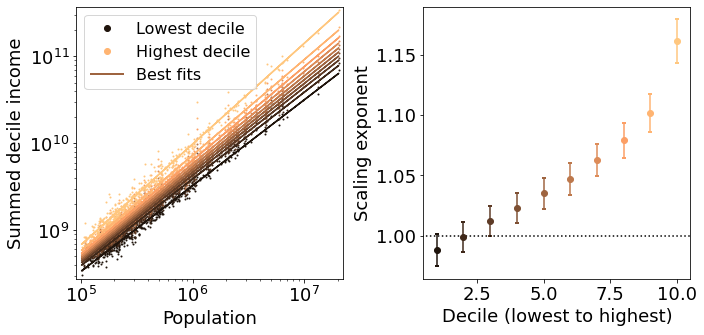

In [6]:
# maps int (1-10) to pair (list of income_pp,list of city size)
deciles = {}
for i in range(1,11):
    deciles[i] = ([],[])

# empirical case:
full_incs = []
for e_income,e_pop,e_ctpop in zip(e_incomes,e_pops,e_ctpops):

        #split into deciles
        sum_pop = sum(e_ctpop)
        pop_cutoffs = [sum_pop*float(i)/10. for i in range(1,11)]
        cumulative_pop = 0.
        current_decile = 1
        # summed population and income for current decile
        decile_pop = 0.
        decile_inc = 0.
        # sort by income
        e_income,e_ctpop = (list(t) for t in zip(*sorted(zip(e_income, e_ctpop))))
        for ctpop, ctinc in zip(e_ctpop,e_income):
            cumulative_pop += ctpop
            decile_pop += ctpop
            decile_inc += ctinc*ctpop
            if cumulative_pop >= pop_cutoffs[(current_decile - 1)]:
    #             if cumulative_pop == pop_cutoffs[9]:
    #                 print("finish reached")
                current_decile += 1
                #store in deciles
                correction = (sum_pop/10.)/(decile_pop)
                decile_inc *= correction 
                #print(correction)
                #print("Decile:",decile_pop,"full/10:",(sum_pop/10.),"with correction",decile_pop*correction)
                
                deciles[(current_decile-1)][0].append(decile_inc)
#                 deciles[(current_decile-1)][0].append(10*decile_inc/sum_pop)
                deciles[(current_decile-1)][1].append(e_pop)
                #reset
                decile_pop = 0
                decile_inc = 0

        sum_inc = np.sum(np.array(e_income)*np.array(e_ctpop))
        full_incs.append(sum_inc)

        
def standardModelFunc(x,y0,delta):
    return y0*(x**(1+delta))
def standardLogResidual(params, x, true_data):
    model = standardModelFunc(x,params['y0'],params['delta'])
    return np.log(true_data)-np.log(model)
        
def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)


def linear(x,b,m):
    return m*x + b

decileFits = {}
decileModels = {}
decileParams = {}
betas = [] #########################
beta_errors = []
beta_ll = []
beta_ul = []
mods = {}
results = {}
ds = [] ############################


def standardLogMod(x,logy0,delta):
    return logy0+x*(1+delta)

# cmap = plt.cm.get_cmap('coolwarm')
cmap =  plt.cm.copper
 

def linear(x,m,b):
    return m*x + b


# Start figure 
plt.rcParams.update({'font.size': 18})

fig = plt.figure(figsize = (11, 5))

ax = plt.subplot(1, 2, 1)

# First panel
for i in range(0,11):
    if i > 0:
        x = list(deciles[i][1])
        y = list(deciles[i][0])
        plt.scatter(x,y,s=1,c=cmap(i/10.))
        logx = np.log(x)
        logy = np.log(y)
    else:
        y,x = full_incs,e_pops
        logx = np.log(x)
        logy = np.log(y)


    mods[i] = lmfit.Model(standardLogMod)
    params = mods[i].make_params(logy0=10**4,delta=0)
    #TODO: Should I fit this in linear space?
    results[i] = mods[i].fit(logy,params,x=logx)
    results[i].conf_interval()
    beta_ll.append(-1*(results[i].ci_out['delta'][1][1] - results[i].ci_out['delta'][3][1]))
    beta_ul.append(results[i].ci_out['delta'][5][1] - results[i].ci_out['delta'][3][1])
    ds.append(i)
    betas.append(results[i].ci_out['delta'][3][1])
    fity = np.exp(np.array(results[i].ci_out['logy0'][3][1],dtype=np.float128))*x**(1+results[i].ci_out['delta'][3][1])
    ax.set_yscale("log")
    ax.set_xscale("log")

    coeff, var = curve_fit(standardLogMod, logx, logy)
#     lbl = "decile "+str(i)+", Beta = "+str(round((1.+coeff[1]),3))
    if i > 0:
        ax.plot(x, fity,'-',markersize=1,c=cmap(i/10.))


# legend cheats
blackdot = mlines.Line2D([], [],color=cmap(0.1), marker="o", linestyle= None,linewidth=0, label= "Lowest decile" )
organgedot = mlines.Line2D([], [],color=cmap(0.9), marker="o", linestyle= None,linewidth=0, label= "Highest decile" )
line = mlines.Line2D([], [],color=cmap(0.5), marker=None, linestyle='-',linewidth=2, label= "Best fits" )

plt.legend(handles = [blackdot, organgedot, line ], loc = 2, fontsize = 16)

        
        
plt.xlim((0.9*np.min(deciles[10][1]), 1.1*np.max(deciles[10][1])))
plt.ylim((0.9*np.min(deciles[1][0]), 1.1*np.max(deciles[10][0])))
plt.xlabel("Population")
# plt.ylabel("Per-Person Income (USD)")
plt.ylabel("Summed decile income")


# plot lines
plt.plot(list(range(0,11)),np.zeros(len(betas)),'--')


# PLOT SECOND PANEL
ax2 = plt.subplot(1, 2, 2)


for i in range(0,11):
    c = cmap(i/10.)
    if i > 0:
        
        #plt.errorbar(0,betas[i]+1,yerr=[[beta_ll[i]],[beta_ul[i]]],label="Total",c='black',fmt='o', ecolor='black', capthick=2,capsize=2)
  
        plt.errorbar(ds[i],betas[i]+1,yerr=[[beta_ll[i]],[beta_ul[i]]],c=c,fmt='o', ecolor=c, capthick=2,capsize=2)
plt.xlabel("Decile (lowest to highest)")
plt.ylabel("Scaling exponent")
# plt.legend()

   
plt.plot([0, 10.5], [1, 1], "k:")
#ax2.set_xticklabels([""] + list(np.arange(10)+1))


mod_bd = lmfit.Model(linear)
params = mod_bd.make_params(m=0,b=0)
results_bd = mod_bd.fit(betas[1:],params,x=[a/10. for a in list(range(1,11))])
results_bd.conf_interval()
print("CI for beta vs. decile: [{},{}]".format(results_bd.ci_out['m'][1][1],results_bd.ci_out['m'][5][1]))
plt.xlim([0.5, 10.5])
plt.subplots_adjust(wspace = 0.3, hspace = 0.00 )





In [7]:
from sklearn.metrics import r2_score

In [8]:
betas_ = betas[1:]
betas1 =[x+1 for x in betas_]
ds_ = ds[1:]
m, b = np.polyfit(ds_, betas1, deg=1)
ls = []
for _ in ds_: 
    y = m*_ +b
    ls.append(y)
r2 = r2_score(betas1, ls)

In [9]:
r2

0.9162314909107189

In [10]:
r2s= []
for i in range(0,11):
    if i > 0:
        x = list(deciles[i][1])
        y = list(deciles[i][0])
        logx = np.log(x)
        logy = np.log(y)
    else:
        y,x = full_incs,e_pops
        logx = np.log(x)
        logy = np.log(y)


    mods[i] = lmfit.Model(standardLogMod)
    params = mods[i].make_params(logy0=10**4,delta=0)
    results[i] = mods[i].fit(logy,params,x=logx)
    results[i].conf_interval()
    beta_ll.append(-1*(results[i].ci_out['delta'][1][1] - results[i].ci_out['delta'][3][1]))
    beta_ul.append(results[i].ci_out['delta'][5][1] - results[i].ci_out['delta'][3][1])
    ds.append(i)
    betas.append(results[i].ci_out['delta'][3][1])
    fity = np.exp(np.array(results[i].ci_out['logy0'][3][1],dtype=np.float128))*x**(1+results[i].ci_out['delta'][3][1])

    ly_ = np.log(fity)
    r2 = r2_score(logy, ly_)
    r2s.append(r2)
    

In [11]:
r2s

[0.9867708808072295,
 0.9828851514982612,
 0.9862209365538566,
 0.9863744458756151,
 0.9858996974904742,
 0.9858761970678591,
 0.9855907578831812,
 0.9851674586133259,
 0.9842531342861726,
 0.9820045533460354,
 0.9782233830199449]